## Velocyto (implemented in R)
元URL: http://pklab.med.harvard.edu/velocyto/notebooks/R/chromaffin2.nb.html

自分のPCでDockerが起動している状態であることを確認してください。
以降の作業はJupyter (R) 上で行います。

In [1]:
library(velocyto.R)

Loading required package: Matrix


### データ読み込み

In [2]:
# 発現量データ
ldat <- readRDS(url("http://pklab.med.harvard.edu/velocyto/chromaffin/ldat.rds"))
# 細胞種アノテーション
cell.colors <- readRDS(url("http://pklab.med.harvard.edu/velocyto/chromaffin/cell.colors.rds"))
# 次元削減後の数値
emb <- readRDS(url("http://pklab.med.harvard.edu/velocyto/chromaffin/embedding.rds"))

In [3]:
# str関数でオブジェクト ldat の内容を情報付きで表示する
str(ldat)

List of 4
 $ spliced  :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:2724270] 3 9 10 13 14 17 19 20 28 29 ...
  .. ..@ p       : int [1:385] 0 7100 14272 21376 28491 36017 43375 50956 57637 64998 ...
  .. ..@ Dim     : int [1:2] 23420 384
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:23420] "Xkr4" "Rp1" "Sox17" "Mrpl15" ...
  .. .. ..$ : chr [1:384] "onefilepercell_A1_unique_and_others_J2CH1:A1_unique.bam" "onefilepercell_A1_unique_and_others_J2CH1:A10_unique.bam" "onefilepercell_A1_unique_and_others_J2CH1:A11_unique.bam" "onefilepercell_A1_unique_and_others_J2CH1:A12_unique.bam" ...
  .. ..@ x       : num [1:2724270] 24 3 22 136 48 21 15 32 109 13 ...
  .. ..@ factors : list()
 $ unspliced:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:1528882] 0 4 10 13 14 17 19 20 23 29 ...
  .. ..@ p       : int [1:385] 0 3911 8043 12057 16176 20795 25046 29389 33438 37382 ...
  .. ..@ Dim     : int [1:2] 23420 384
  .. ..@

In [4]:
# 細胞名から余分な文字列を削除
ldat <- lapply(ldat,function(x) {
  colnames(x) <-  gsub("_unique.bam","",gsub(".*:","",colnames(x)))
  x
})

### Gene filtering

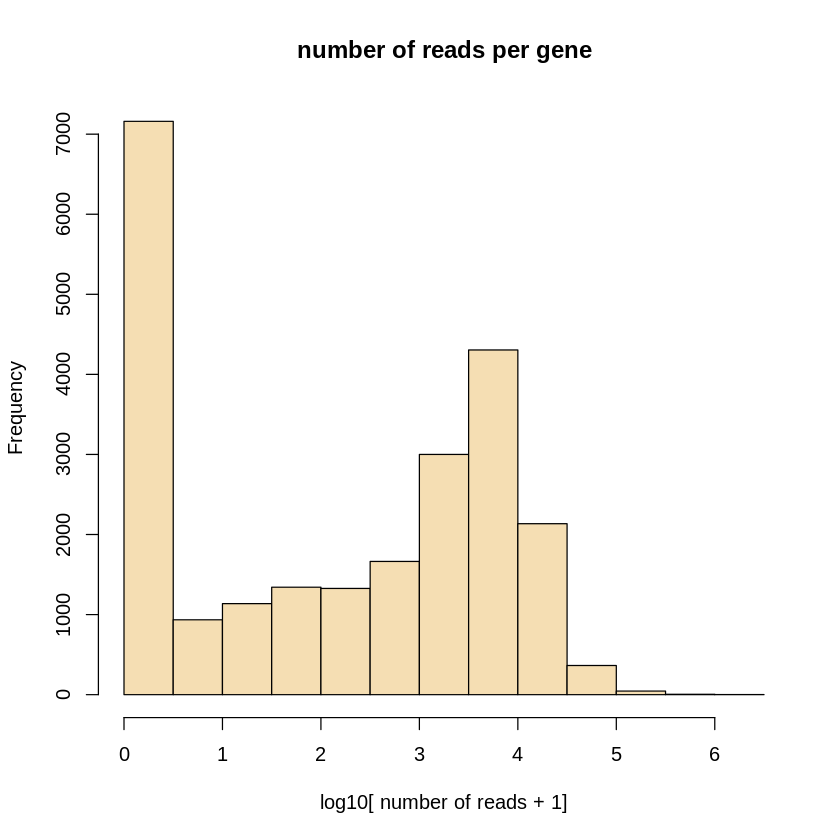

In [5]:
#Spliced expression magnitude distribution across genes:
hist(log10(rowSums(ldat$spliced)+1),col='wheat',xlab='log10[ number of reads + 1]',main='number of reads per gene')

Set up expression matrices, filtering genes to leave those that exceed some pre-defined g to the average expression magnitude

In [6]:
# exonic read (spliced) expression matrix
emat <- ldat$spliced;
# intronic read (unspliced) expression matrix
nmat <- ldat$unspliced
# spanning read (intron+exon) expression matrix
smat <- ldat$spanning;
# filter expression matrices based on some minimum max-cluster averages
emat <- filter.genes.by.cluster.expression(emat,cell.colors,min.max.cluster.average = 5)
nmat <- filter.genes.by.cluster.expression(nmat,cell.colors,min.max.cluster.average = 1)
smat <- filter.genes.by.cluster.expression(smat,cell.colors,min.max.cluster.average = 0.5)
# look at the resulting gene set
length(intersect(rownames(emat),　rownames(nmat)))

[1] 8548

In [7]:
# and if we use spanning reads (smat)
length(intersect(intersect(rownames(emat),rownames(nmat)),rownames(smat)))

[1] 1696

### RNA velocityの推定

In [8]:
# Several variants of velocity estimates using gene-relative model
# Here the fit is based on the top/bottom 5% of cells (by spliced expression magnitude)
fit.quantile <- 0.05;
rvel.qf <- gene.relative.velocity.estimates(emat, nmat, deltaT=1, kCells = 5, fit.quantile = fit.quantile)

calculating cell knn ... done
calculating convolved matrices ... done
fitting gamma coefficients ... done. succesfful fit for 8548 genes
filtered out 1306 out of 8548 genes due to low nmat-emat correlation
filtered out 754 out of 7242 genes due to low nmat-emat slope
calculating RNA velocity shift ... done
calculating extrapolated cell state ... done


log ... pca ... pc multipliers ... delta norm ... done
done


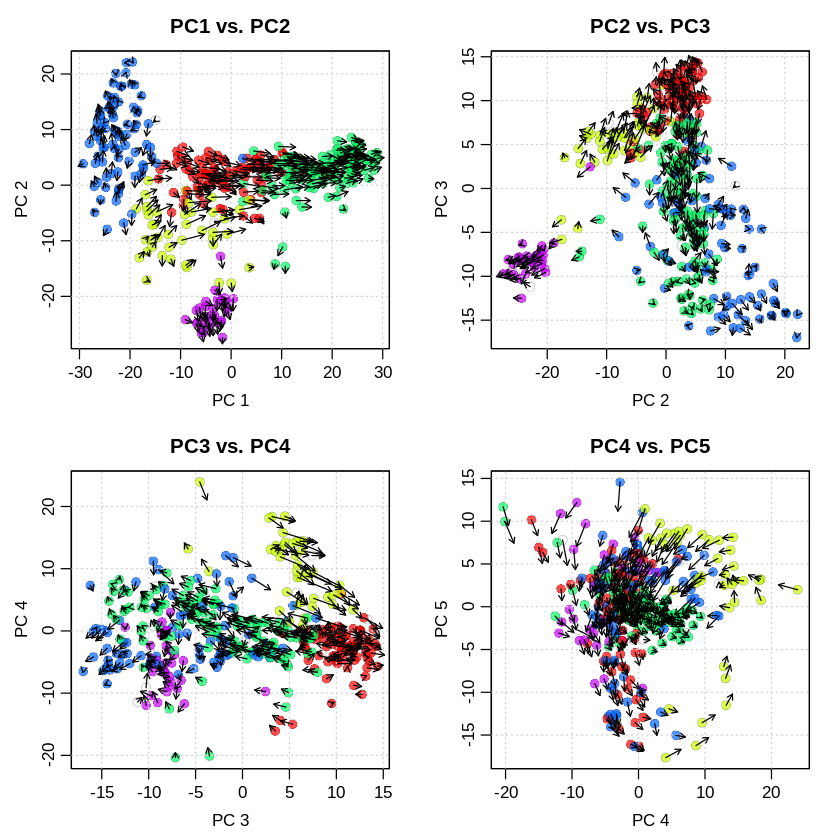

In [9]:
# 可視化（PCAプロット上で）
pca.velocity.plot(rvel.qf, nPcs=5, plot.cols=2,
                  cell.colors=ac(cell.colors, alpha=0.7),
                  cex=1.2, pcount=0.1,
                  pc.multipliers=c(1,-1,-1,-1,-1))

calculating convolved matrices ... done


[1] 1

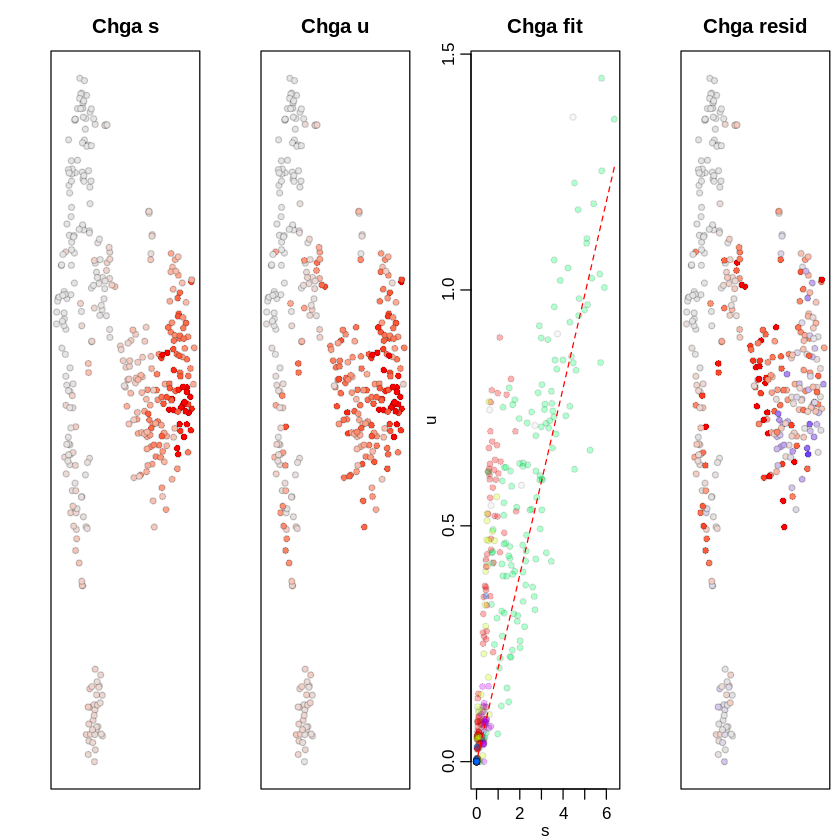

In [10]:
# show.gene オプションを使うと指定した遺伝子を可視化できる
# define custom pallet for expression magnitude
gene.relative.velocity.estimates(emat, nmat,
                                 kCells = 5,
                                 fit.quantile = fit.quantile,
                                 old.fit=rvel.qf,
                                 show.gene='Chga',
                                 cell.emb=emb,
                                 cell.colors=cell.colors)

In [11]:
# (optional) spanning reads (smat) を用いたRNA velocity 推定
# much fewer genes (spanning reads are rare).
rvel <- gene.relative.velocity.estimates(emat, nmat, smat=smat, 
                                         kCells = 5,
                                         fit.quantile=fit.quantile,
                                         diagonal.quantiles = TRUE)

calculating cell knn ... done
calculating convolved matrices ... done
fitting smat-based offsets ... done
fitting gamma coefficients ... done. succesfful fit for 1696 genes
filtered out 26 out of 1696 genes due to low nmat-smat correlation
filtered out 138 out of 1670 genes due to low nmat-emat correlation
filtered out 14 out of 1532 genes due to low nmat-emat slope
calculating RNA velocity shift ... done
calculating extrapolated cell state ... done


log ... pca ... pc multipliers ... delta norm ... done
done


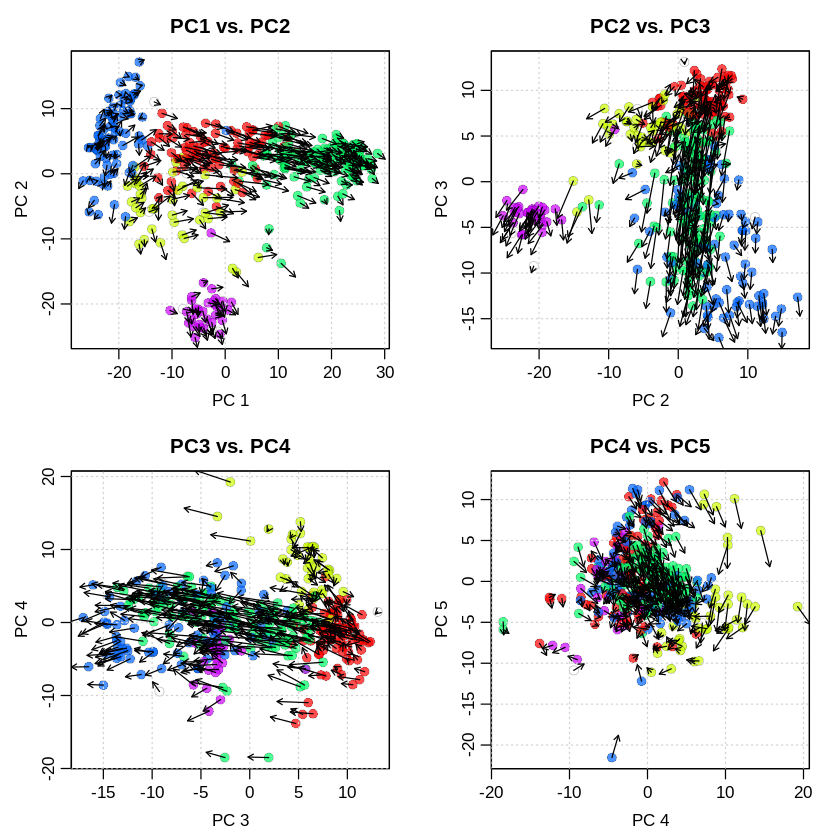

In [12]:
pca.velocity.plot(rvel, nPcs=5,
                  plot.cols=2,
                  cell.colors=ac(cell.colors,alpha=0.7),
                  cex=1.2,
                  pcount=0.1,
                  pc.multipliers=c(1,-1,1,1,1))

In [13]:
# calculate the most basic version of velocity estimates, using relative gamma fit,
# without cell kNN smoothing (i.e. actual single-cell velocity):
rvel1 <- gene.relative.velocity.estimates(emat,nmat,deltaT=1,deltaT2 = 1,kCells = 1, fit.quantile=fit.quantile)

fitting gamma coefficients ... done. succesfful fit for 8548 genes
filtered out 783 out of 8548 genes due to low nmat-emat correlation
filtered out 1330 out of 7765 genes due to low nmat-emat slope
calculating RNA velocity shift ... done
calculating extrapolated cell state ... done


log ... pca ... pc multipliers ... delta norm ... done
done


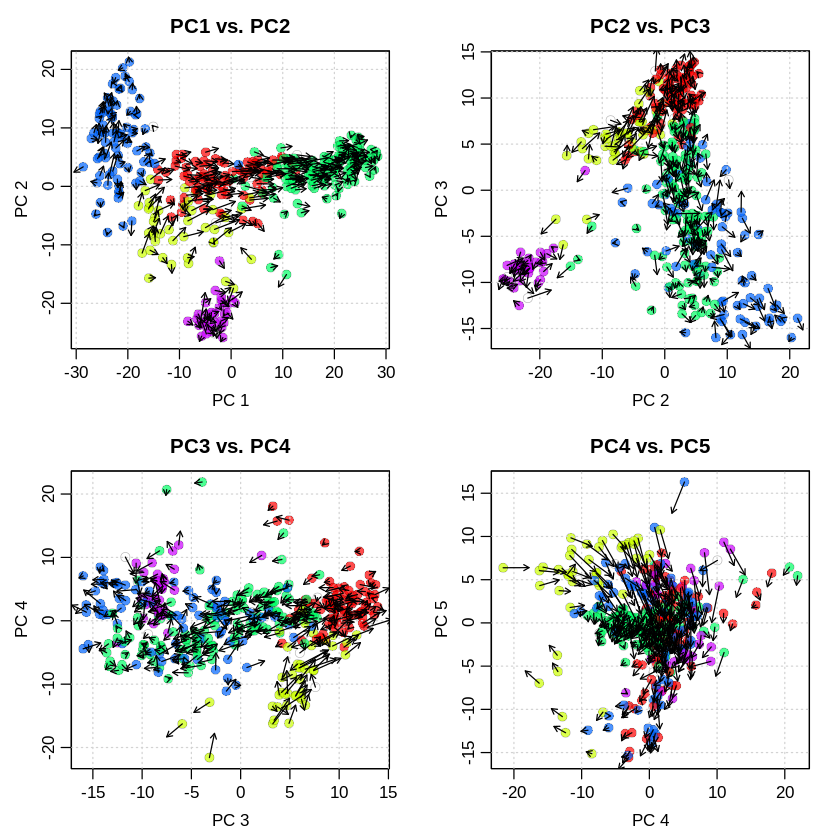

In [14]:
pca.velocity.plot(rvel1,nPcs=5,
                  plot.cols=2,
                  cell.colors=ac(cell.colors,alpha=0.7),
                  cex=1.2,pcount=0.1,
                  pc.multipliers=c(1,-1,1,1,1))

delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done


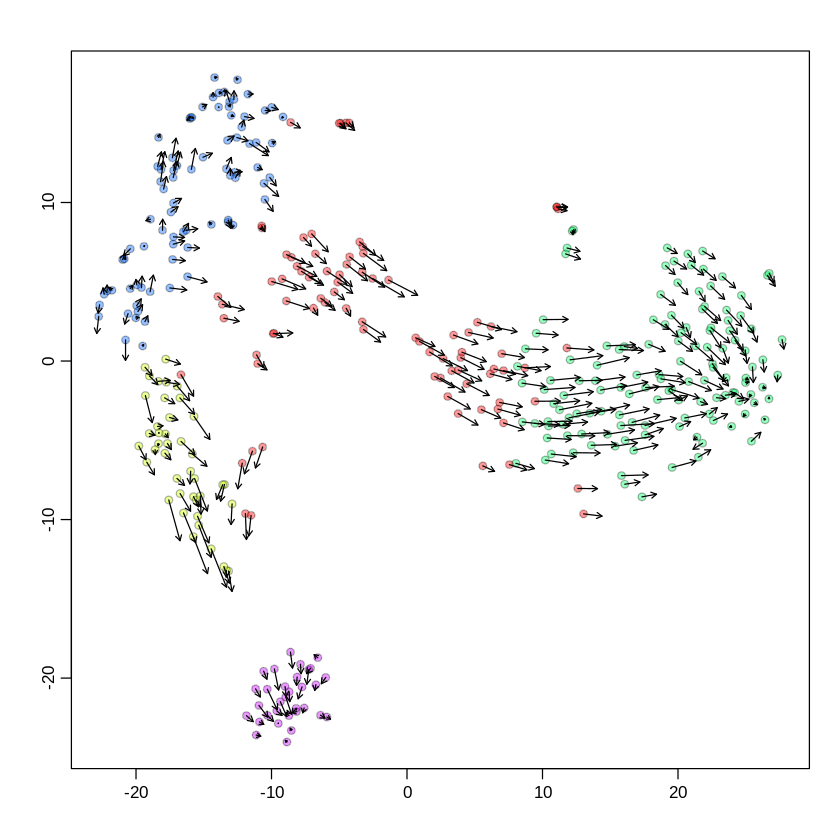

In [15]:
### tSNE上での可視化
vel <- rvel; arrow.scale=3; cell.alpha=0.4; cell.cex=1; fig.height=4; fig.width=4.5;
show.velocity.on.embedding.cor(emb,vel,n=100,scale='sqrt',cell.colors=ac(cell.colors,alpha=cell.alpha),cex=cell.cex,arrow.scale=arrow.scale,arrow.lwd=1)

delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done
grid estimates ... grid.sd= 1.731696  min.arrow.size= 0.03463392  max.grid.arrow.length= 0.1013337  done


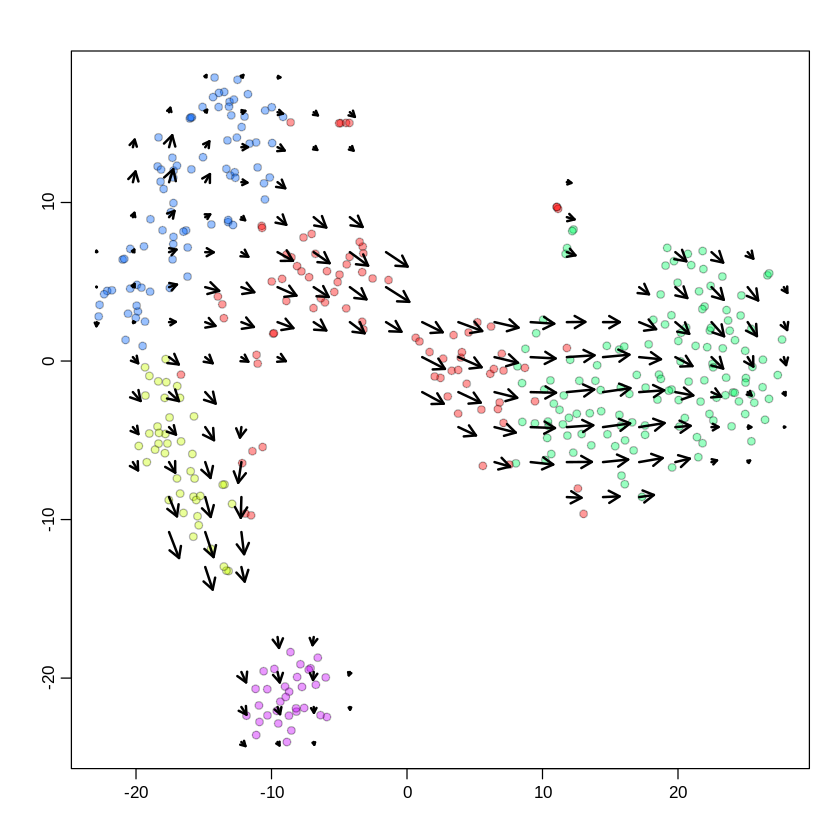

In [16]:
# Alternatively, the same function can be used to calculate a velocity vector field:
show.velocity.on.embedding.cor(emb,vel,n=100,scale='sqrt',
                               cell.colors=ac(cell.colors,alpha=cell.alpha),
                               cex=cell.cex,arrow.scale=arrow.scale,show.grid.flow=TRUE,
                               min.grid.cell.mass=0.5,grid.n=20,arrow.lwd=2)

### Velocity estimate based on gene structure

In [21]:
# 遺伝子データダウンロード
ip.mm10 <- readRDS(url("http://pklab.med.harvard.edu/velocyto/chromaffin/ip.mm10.rds"))

In [24]:
# ゲノムデータダウンロード
gene.info <- readRDS(url("http://pklab.med.harvard.edu/velocyto/chromaffin/gene.info.rds"))
#gene.info <- read.gene.mapping.info("onefilepercell_A1_unique_and_others_J2CH1.hdf5",
#                                    internal.priming.info=ip.mm10,min.exon.count=10);

In [25]:
# start with unfiltered matrices, as we can use more genes in these types of estimates
emat <- ldat$spliced; nmat <- ldat$unspliced; smat <- ldat$spanning
emat <- filter.genes.by.cluster.expression(emat,cell.colors,min.max.cluster.average = 7)
gvel <- global.velcoity.estimates(emat, nmat, rvel, base.df=gene.info$gene.df, smat=smat, deltaT=1, kCells=5, kGenes = 15, kGenes.trim = 5, min.gene.cells = 0, min.gene.conuts = 500)

filtered out 4 out of 8990 genes due to low emat levels
filtered out 1072 out of 8986 genes due to insufficient exonic or intronic lengths
filtered out 204 out of 7914 genes due to excessive nascent counts
using relative slopes for 1221 genes to fit structure-based model ... with internal priming info ... 80.5% deviance explained.
predicting gamma ... done
refitting offsets ... calculating cell knn ... done
calculating convolved matrices ... done
fitting smat-based offsets ... done
fitting gamma coefficients ... done. succesfful fit for 7694 genes
filtered out 1337 out of 7551 genes due to low nmat-smat correlation
filtered out 899 out of 6214 genes due to low nmat-emat correlation
filtered out 440 out of 5315 genes due to low nmat-emat slope
calculating RNA velocity shift ... done
calculating extrapolated cell state ... done
re-estimated offsets for 6214 out of 7710 genes
calculating convolved matrices ... done
calculating gene knn ... done
estimating M values ... adjusting mval offse

log ... pca ... pc multipliers ... delta norm ... done
done


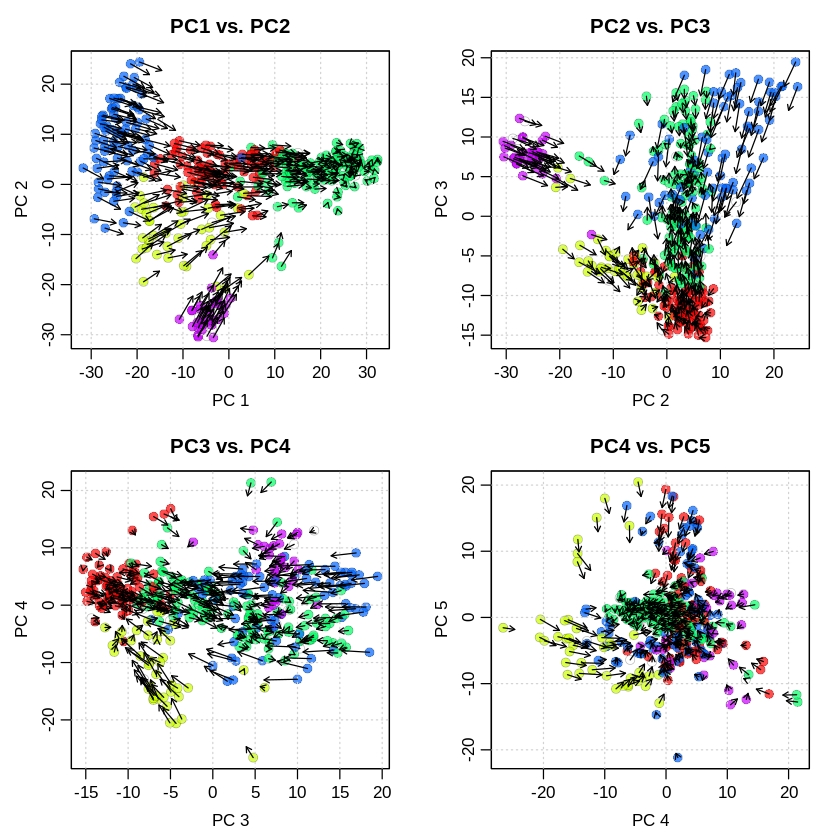

In [26]:
pca.velocity.plot(gvel,nPcs=5,plot.cols=2,cell.colors=ac(cell.colors,alpha=0.7),cex=1.2,pcount=0.1,pc.multipliers=c(1,-1,-1,1,1))

delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done
delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done


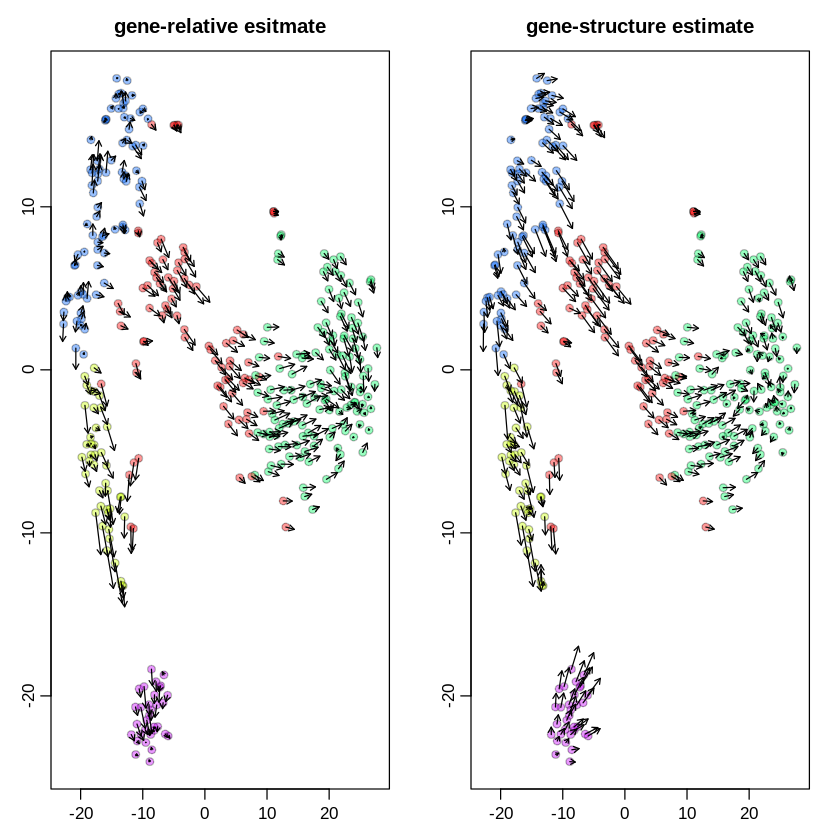

In [30]:
par(mfrow=c(1,2), mar = c(2.5,2.5,2.5,1.5), mgp = c(2,0.65,0), cex = 0.85);
arrow.scale=3; cell.alpha=0.4; cell.cex=1; fig.height=4; fig.width=4.5;

#pdf(file='tsne.rvel_gvel.plots.pdf',height=6,width=12)
show.velocity.on.embedding.cor(emb,rvel,n=100,scale='sqrt',cell.colors=ac(cell.colors,alpha=cell.alpha),cex=cell.cex,arrow.scale=arrow.scale,arrow.lwd=1,main='gene-relative esitmate',do.par=F)
show.velocity.on.embedding.cor(emb,gvel,n=100,scale='sqrt',cell.colors=ac(cell.colors,alpha=cell.alpha),cex=cell.cex,arrow.scale=arrow.scale,arrow.lwd=1,main='gene-structure estimate',do.par=F)
#dev.off()

rescaling ... log ... pca ... delta norm ... tSNE ...Performing PCA
Read the 768 x 15 data matrix successfully!
OpenMP is working. 32 threads.
Using no_dims = 2, perplexity = 200.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 1.14 seconds (sparsity = 0.903880)!
Learning embedding...
Iteration 50: error is 45.227905 (50 iterations in 11.93 seconds)
Iteration 100: error is 45.227208 (50 iterations in 6.67 seconds)
Iteration 150: error is 44.496775 (50 iterations in 3.81 seconds)
Iteration 200: error is 44.370803 (50 iterations in 3.64 seconds)
Iteration 250: error is 44.370911 (50 iterations in 3.66 seconds)
Iteration 300: error is 0.166531 (50 iterations in 4.67 seconds)
Iteration 350: error is 0.159202 (50 iterations in 3.87 seconds)
Iteration 400: error is 0.157654 (50 iterations in 10.38 seconds)
Iteration 450: error is 0.158003 (50 iterations in 3.08 seconds)
Iteration 500: error is 0.158254 (50 iterations in 3.75 seconds)
Iteration 550: error 

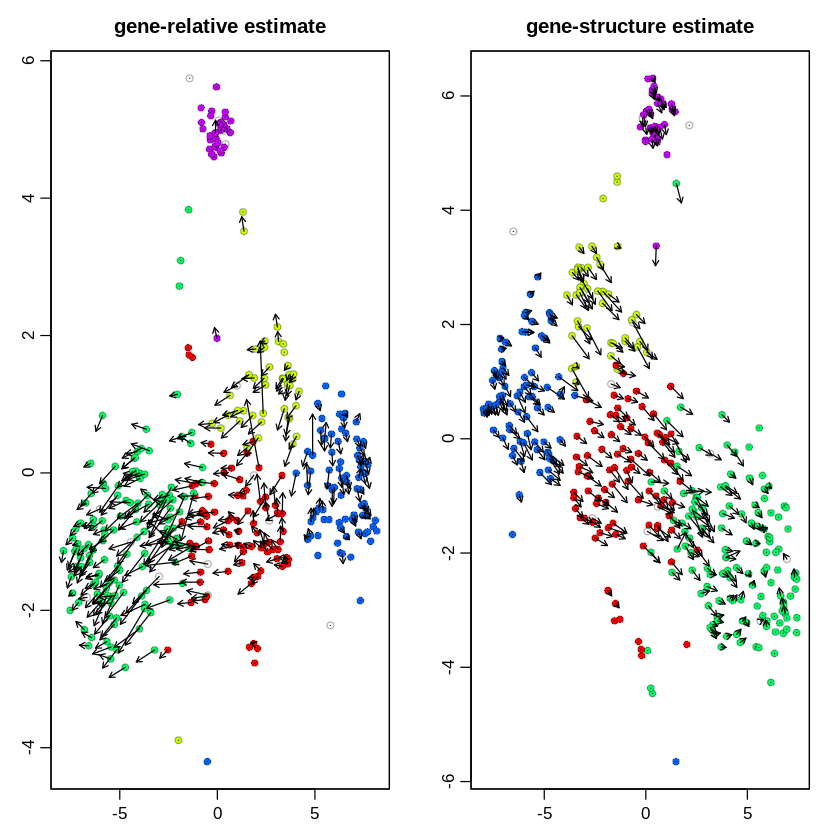

In [31]:
#pdf(file='tsne.shift.plots.pdf',height=6,width=12)
par(mfrow=c(1,2), mar = c(2.5,2.5,2.5,1.5), mgp = c(2,0.65,0), cex = 0.85);
x <- tSNE.velocity.plot(rvel,nPcs=15,cell.colors=cell.colors,cex=0.9,perplexity=200,norm.nPcs=NA,pcount=0.1,scale='log',do.par=F,main='gene-relative estimate')
x <- tSNE.velocity.plot(gvel,nPcs=15,cell.colors=cell.colors,cex=0.9,perplexity=200,norm.nPcs=NA,pcount=0.1,scale='log',do.par=F,main='gene-structure estimate')
#dev.off()

sqrt scale ... reducing to 30 PCs ... distance ... sigma= 2.5  beta= 1  transition probs ... embedding kNN ... done
simulating diffusion ... constructing path graph ... tracing shortest trajectories ... clustering ... done.


Warning message in arrows(bp$x[ai], bp$y[ai], bp$x[ai + 1], bp$y[ai + 1], angle = 30, :
“zero-length arrow is of indeterminate angle and so skipped”

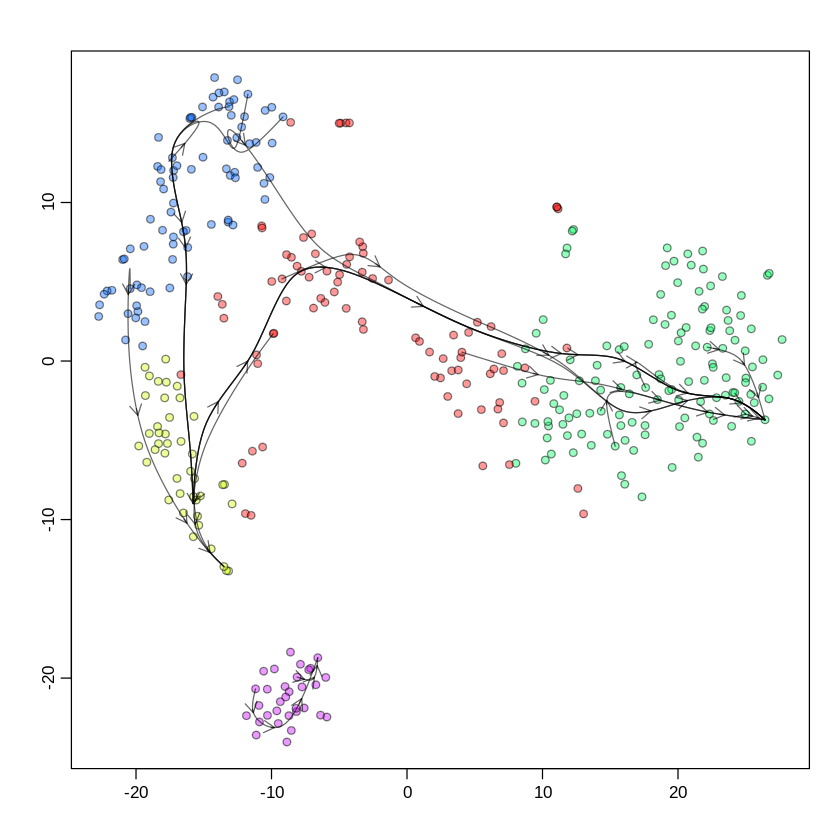

In [35]:
# Cell trajectory modeling
# 注！計算量が大きいです
x <- show.velocity.on.embedding.eu(emb,rvel,n=40,scale='sqrt',
                                   cell.colors=ac(cell.colors,alpha=cell.alpha),
                                   cex=cell.cex,
                                   nPcs=30,
                                   sigma=2.5,show.trajectories=TRUE,
                                   diffusion.steps=400,
                                   n.trajectory.clusters=15,
                                   ntop.trajectories=1,
                                   embedding.knn=T,control.for.neighborhood.density=TRUE,
                                   n.cores=4) 